In [7]:
import sys
sys.path.insert(0, '../core')

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
import kaggle_support as kgs
import pack_cost
import pack_minkowski as mink
from shapely import affinity

# Initialize
kgs.set_float32(True)

print(f"Tree max radius: {kgs.tree_max_radius:.4f}")
print(f"Tree area: {kgs.tree_area:.4f}")

Tree max radius: 0.5796
Tree area: 0.2457


## Create Cost Function and Build LUT

In [8]:
# Create the exact separation cost with smaller LUT for testing
cost_fn_exact = pack_cost.CollisionCostExactSeparation(
    use_lookup_table=True,
    lut_N_x=500,
    lut_N_y=500,
    lut_N_theta=180,
    lut_trim_zeros=True,
    scaling=1.0
)

# Also create SAT-based separation cost for comparison
cost_fn_sat = pack_cost.CollisionCostOverlappingArea(
    use_lookup_table=False,
    scaling=1.0
)

# Force LUT initialization for exact
cost_fn_exact._ensure_lut_initialized()

print(f"\nExact Minkowski LUT built successfully!")
print(f"LUT grid size: {cost_fn_exact._lut.N_x} x {cost_fn_exact._lut.N_y} x {cost_fn_exact._lut.N_theta}")
print(f"LUT value range: [{cost_fn_exact._lut.vals.min():.4f}, {cost_fn_exact._lut.vals.max():.4f}]")

Building lookup table for CollisionCostExactSeparation using Minkowski difference...
Building LUT: 251 x 500 x 180 = 22,590,000 grid points
  Processing theta 1/180
  Processing theta 51/180
  Processing theta 101/180
  Processing theta 151/180
Cost range: [-1.093343, 0.629047]
Trimming zero edges:
  X: 251 -> 251 (removed 0)
  Y: 500 -> 500 (removed 0)
  Theta: 180 -> 180 (removed 0)
  Total reduction: 0.0% (0 points)

Exact Minkowski LUT built successfully!
LUT grid size: 251 x 500 x 180
LUT value range: [-1.0933, 0.6290]


## Test on Two-Tree Configurations

In [9]:
# Test various two-tree configurations
test_cases = [
    {"name": "Overlapping", "x1": 0.0, "y1": 0.0, "t1": 0.0, "x2": 0.5, "y2": 0.0, "t2": 0.0},
    {"name": "Just touching", "x1": 0.0, "y1": 0.0, "t1": 0.0, "x2": 1.0, "y2": 0.0, "t2": 0.0},
    {"name": "Separated", "x1": 0.0, "y1": 0.0, "t1": 0.0, "x2": 1.5, "y2": 0.0, "t2": 0.0},
    {"name": "Rotated 45°", "x1": 0.0, "y1": 0.0, "t1": 0.0, "x2": 0.5, "y2": 0.5, "t2": np.pi/4},
    {"name": "Rotated 90°", "x1": 0.0, "y1": 0.0, "t1": 0.0, "x2": 0.0, "y2": 0.8, "t2": np.pi/2},
]

print("Testing two-tree configurations:")
print("-" * 90)
print(f"{'Configuration':20s} {'Exact Minkowski':>20s} {'SAT-based':>20s} {'Difference':>20s}")
print("-" * 90)

for tc in test_cases:
    # Create solution with 2 trees
    xyt = np.array([
        [tc["x1"], tc["y1"], tc["t1"]],
        [tc["x2"], tc["y2"], tc["t2"]]
    ], dtype=np.float32)
    
    xyt_cp = cp.asarray(xyt[None, :, :])  # Add batch dimension
    
    sol = kgs.SolutionCollectionSquare()
    sol.xyt = xyt_cp
    sol.h = cp.array([[10., 0., 0.]], dtype=cp.float32)
    sol.check_constraints()
    
    # Compute cost with exact
    cost_exact, _, _ = cost_fn_exact.compute_cost_allocate(sol, evaluate_gradient=True)
    cost_exact_val = cost_exact.get()[0]
    
    # Compute cost with SAT
    cost_sat, _, _ = cost_fn_sat.compute_cost_allocate(sol, evaluate_gradient=True)
    cost_sat_val = cost_sat.get()[0]
    
    diff = abs(cost_exact_val - cost_sat_val)
    
    print(f"{tc['name']:20s} {cost_exact_val:20.6f} {cost_sat_val:20.6f} {diff:20.6f}")

Testing two-tree configurations:
------------------------------------------------------------------------------------------
Configuration             Exact Minkowski            SAT-based           Difference
------------------------------------------------------------------------------------------
Overlapping                      0.019130             0.010004             0.009126
Just touching                    0.000000             0.000000             0.000000
Separated                        0.000000             0.000000             0.000000
Rotated 45°                      0.000000             0.000000             0.000000
Rotated 90°                      0.000000             0.000000             0.000000


## Visualize Separation Distance Field

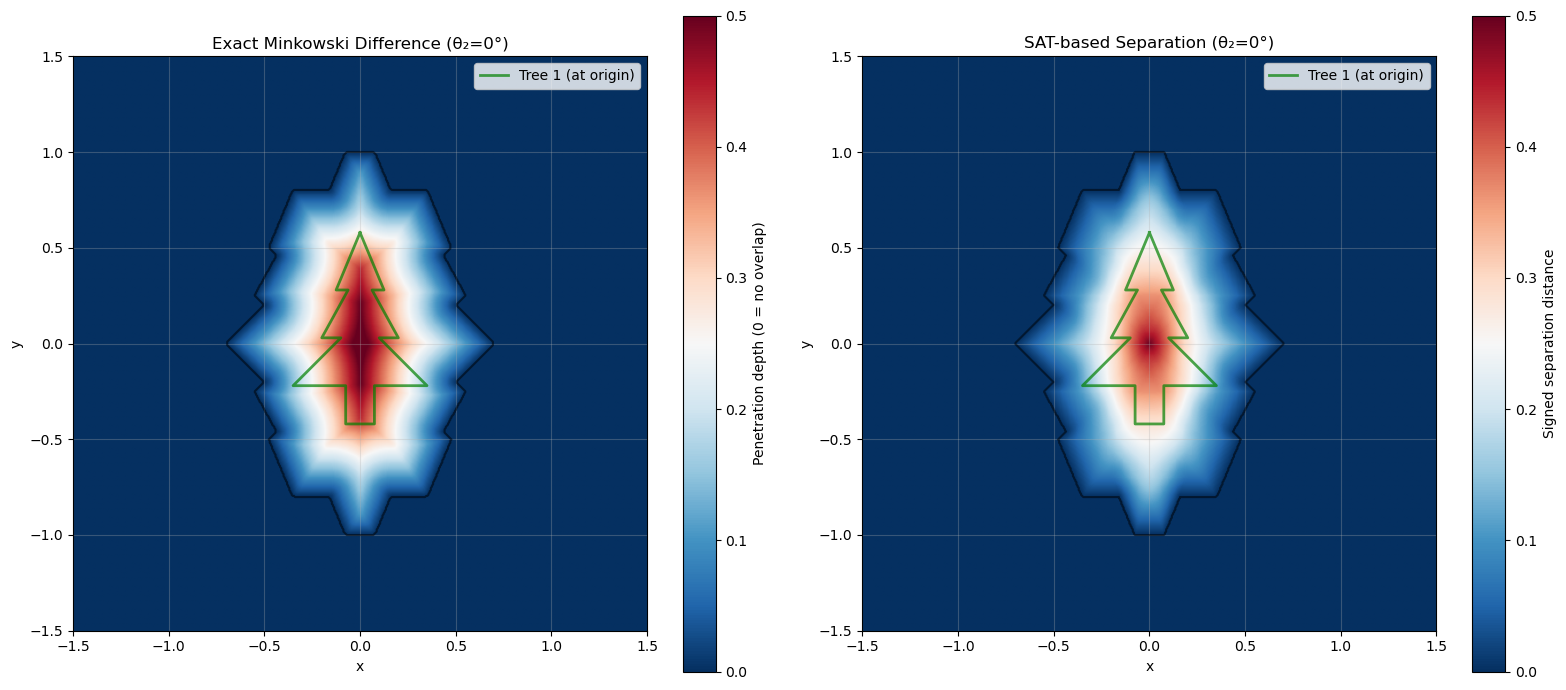

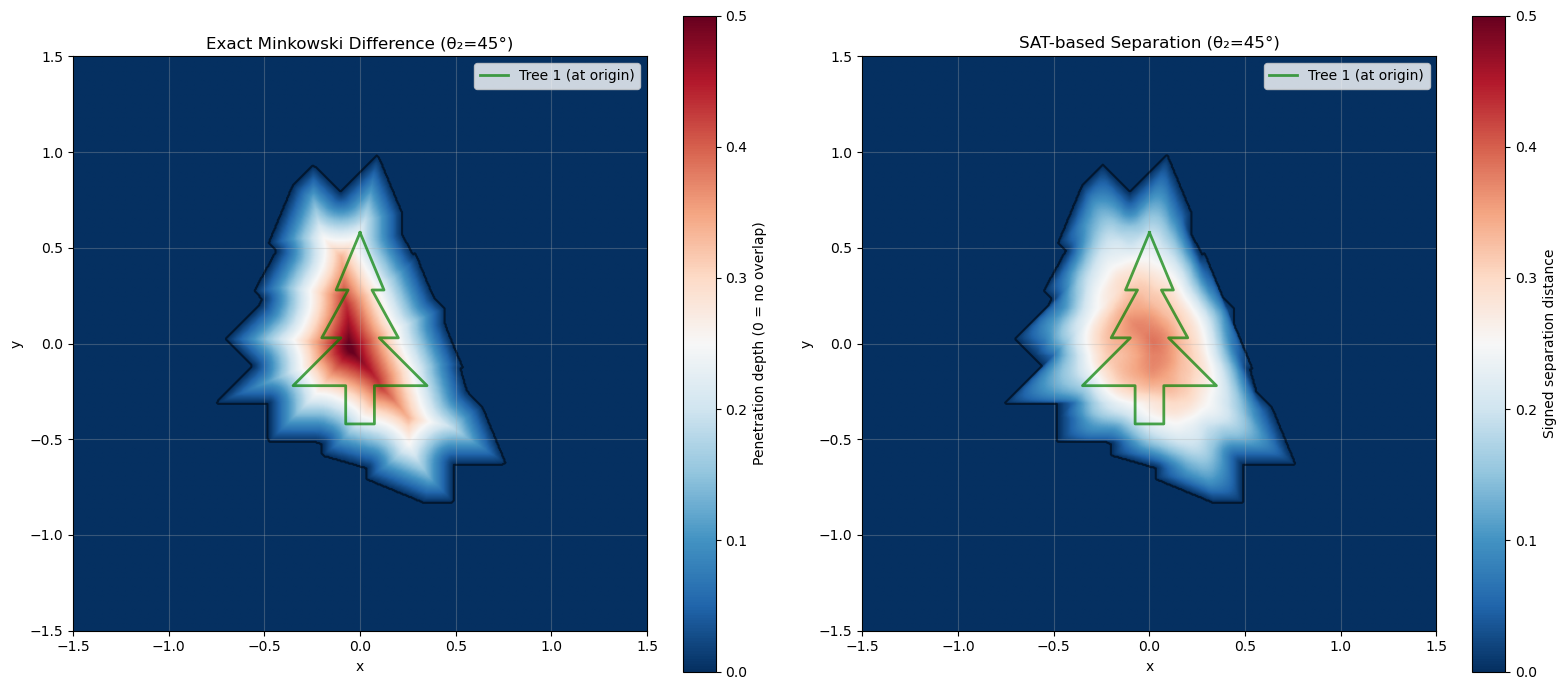

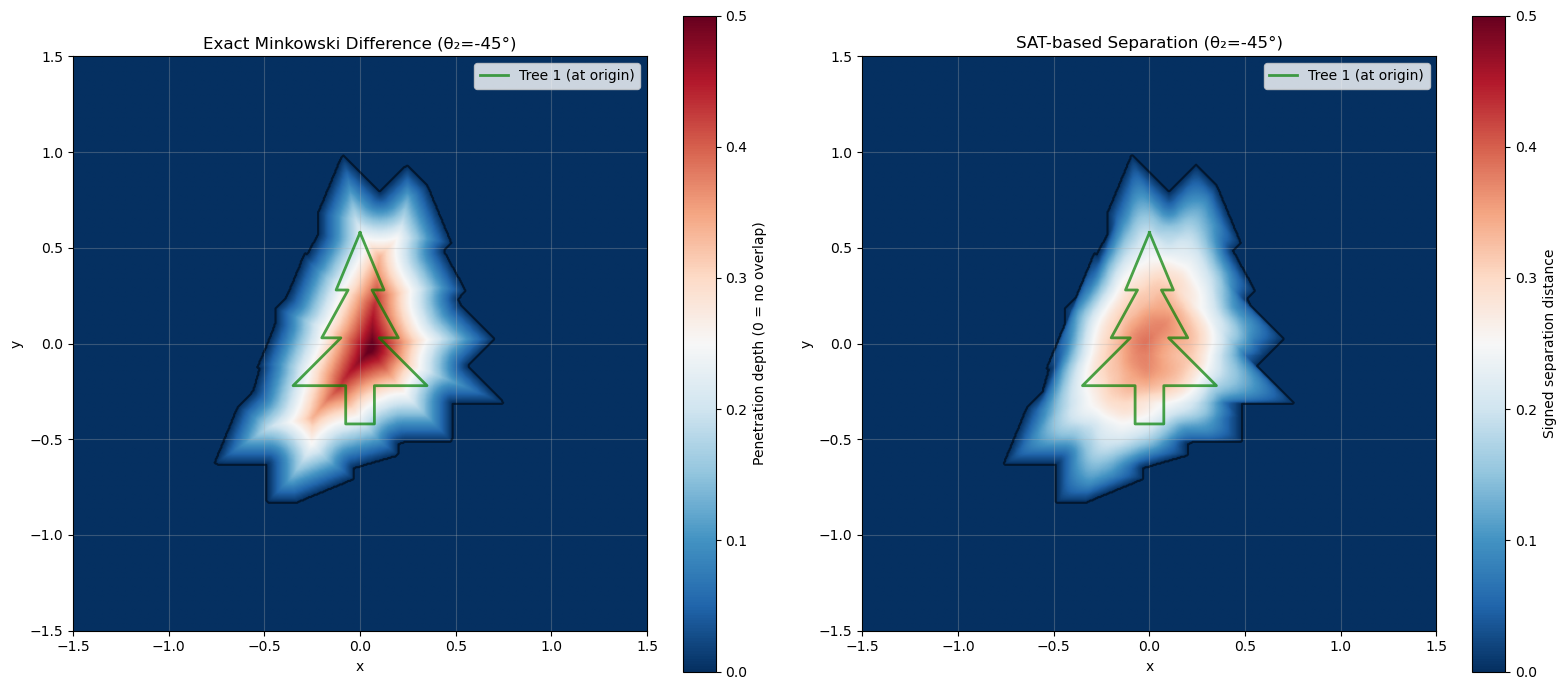

In [10]:
def plot_separation_field(theta2_deg, resolution=500):
    """
    Plot comparison of exact Minkowski vs SAT-based separation fields.
    
    Tree1 is at origin with rotation 0.
    Shows signed separation distance across a grid of tree2 positions.
    """
    theta2 = np.radians(theta2_deg)
    
    # Create a grid of tree2 positions
    x_range = np.linspace(-1.5, 1.5, resolution)
    y_range = np.linspace(-1.5, 1.5, resolution)
    xx, yy = np.meshgrid(x_range, y_range)
    
    # For each grid point, compute cost using both methods
    N = resolution * resolution
    xyt_batch = np.zeros((N, 2, 3), dtype=np.float32)
    # Tree 0 at origin
    xyt_batch[:, 0, :] = [0, 0, 0]
    # Tree 1 at grid positions
    xyt_batch[:, 1, 0] = xx.ravel()
    xyt_batch[:, 1, 1] = yy.ravel()
    xyt_batch[:, 1, 2] = theta2
    
    xyt_cp = cp.asarray(xyt_batch)
    sol = kgs.SolutionCollectionSquare()
    sol.xyt = xyt_cp
    sol.h = cp.tile(cp.array([[10., 0., 0.]], dtype=cp.float32), (N, 1))
    sol.check_constraints()
    
    # Compute costs with exact Minkowski
    costs_exact, _, _ = cost_fn_exact.compute_cost_allocate(sol, evaluate_gradient=False)
    costs_exact_np = costs_exact.get()
    # Convert cost = max(0, sep)^2 back to separation
    # Cost > 0 means overlap, cost = 0 means clearance
    # For visualization, we need signed separation (positive = overlap)
    # Note: we lose information about clearance distance (all become 0)
    sep_field_exact = np.sqrt(costs_exact_np)  # Always >= 0
    sep_field_exact = sep_field_exact.reshape(resolution, resolution)
    
    # Compute costs with SAT-based
    costs_sat, _, _ = cost_fn_sat.compute_cost_allocate(sol, evaluate_gradient=False)
    costs_sat_np = costs_sat.get()
    # SAT returns signed separation already
    sep_field_sat = np.sqrt(np.abs(costs_sat_np)) * np.sign(costs_sat_np)
    sep_field_sat = sep_field_sat.reshape(resolution, resolution)
    
    # Get trees for visualization
    tree1 = kgs.center_tree
    tree2 = mink.get_rotated_tree(theta2)
    
    # Plot side by side
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Left: Exact Minkowski
    ax = axes[0]
    im = ax.imshow(sep_field_exact, extent=[-1.5, 1.5, -1.5, 1.5], origin='lower',
                   cmap='RdBu_r', vmin=0, vmax=0.5)
    ax.contour(xx, yy, sep_field_exact, levels=[0], colors='black', linewidths=1.5, alpha=0.5)
    x, y = tree1.exterior.xy
    ax.plot(x, y, 'g-', linewidth=2, label='Tree 1 (at origin)', alpha=0.7)
    plt.colorbar(im, ax=ax, label='Penetration depth (0 = no overlap)')
    ax.set_title(f'Exact Minkowski Difference (θ₂={theta2_deg:.0f}°)')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Right: SAT-based
    ax = axes[1]
    im = ax.imshow(sep_field_sat, extent=[-1.5, 1.5, -1.5, 1.5], origin='lower',
                   cmap='RdBu_r', vmin=0, vmax=0.5)
    ax.contour(xx, yy, sep_field_sat, levels=[0], colors='black', linewidths=1.5, alpha=0.5)
    x, y = tree1.exterior.xy
    ax.plot(x, y, 'g-', linewidth=2, label='Tree 1 (at origin)', alpha=0.7)
    plt.colorbar(im, ax=ax, label='Signed separation distance')
    ax.set_title(f'SAT-based Separation (θ₂={theta2_deg:.0f}°)')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    return fig
plot_separation_field(0)
plot_separation_field(45);
plot_separation_field(-45);

## Test Gradient Computation

In [11]:
# Test that gradients are computed correctly
# For overlapping configuration
xyt = np.array([
    [0.0, 0.0, 0.0],
    [0.5, 0.0, 0.0]
], dtype=np.float32)

xyt_cp = cp.asarray(xyt[None, :, :])
sol = kgs.SolutionCollectionSquare()
sol.xyt = xyt_cp
sol.h = cp.array([[10., 0., 0.]], dtype=cp.float32)
sol.check_constraints()

# Compute with gradient
cost, grad_xyt, grad_h = cost_fn_exact.compute_cost_allocate(sol, evaluate_gradient=True)

print(f"Cost: {cost.get()[0]:.6f}")
print(f"Gradient xyt:\n{grad_xyt.get()[0]}")
print(f"Gradient h: {grad_h.get()[0]}")

# Verify gradient with finite differences
eps = 1e-5
sol_plus = kgs.SolutionCollectionSquare()
sol_plus.xyt = xyt_cp.copy()
sol_plus.xyt[0, 1, 0] += eps  # Perturb x of tree 1
sol_plus.h = cp.array([[10., 0., 0.]], dtype=cp.float32)
sol_plus.check_constraints()

cost_plus, _, _ = cost_fn_exact.compute_cost_allocate(sol_plus, evaluate_gradient=False)
grad_x_fd = (cost_plus.get()[0] - cost.get()[0]) / eps

print(f"\nFinite difference check for grad_x[tree 1]:")
print(f"  Analytical: {grad_xyt.get()[0, 1, 0]:.6f}")
print(f"  Finite diff: {grad_x_fd:.6f}")
print(f"  Difference: {abs(grad_xyt.get()[0, 1, 0] - grad_x_fd):.8f}")

Cost: 0.019130
Gradient xyt:
[[ 0.1972995   0.00173088  0.02398285]
 [-0.1972995  -0.00173088 -0.0231174 ]]
Gradient h: [0. 0. 0.]

Finite difference check for grad_x[tree 1]:
  Analytical: -0.197299
  Finite diff: -0.197999
  Difference: 0.00069968
